## Dynamic Time Wraping

A technique for comparing two, typically temporal, sequences that are not quite synchronized is called **dynamic time warping**, or DTW. It is a technique to determine how well two sequences match. DTW is helpful in a variety of fields, including financial markets, data mining, and speech recognition. The measurement of the separation between two-time series is frequently employed in data mining.

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

# Dataset
from darts.datasets import HeartRateDataset

# Processing 
from darts.dataprocessing import dtw
from darts.timeseries import TimeSeries
from darts.metrics import dtw_metric, mae
from darts.models import MovingAverageFilter
from scipy.signal import argrelextrema

c:\Users\yukse\Desktop\Yuksel\Yucas\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SMALL_SIZE = 30
MEDIUM_SIZE = 35
BIGGER_SIZE = 40
FIG_WIDTH = 20
FIG_SIZE = (40, 10)


plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=FIG_SIZE)  # size of the figure

### Pre-processing

92.59611438888888


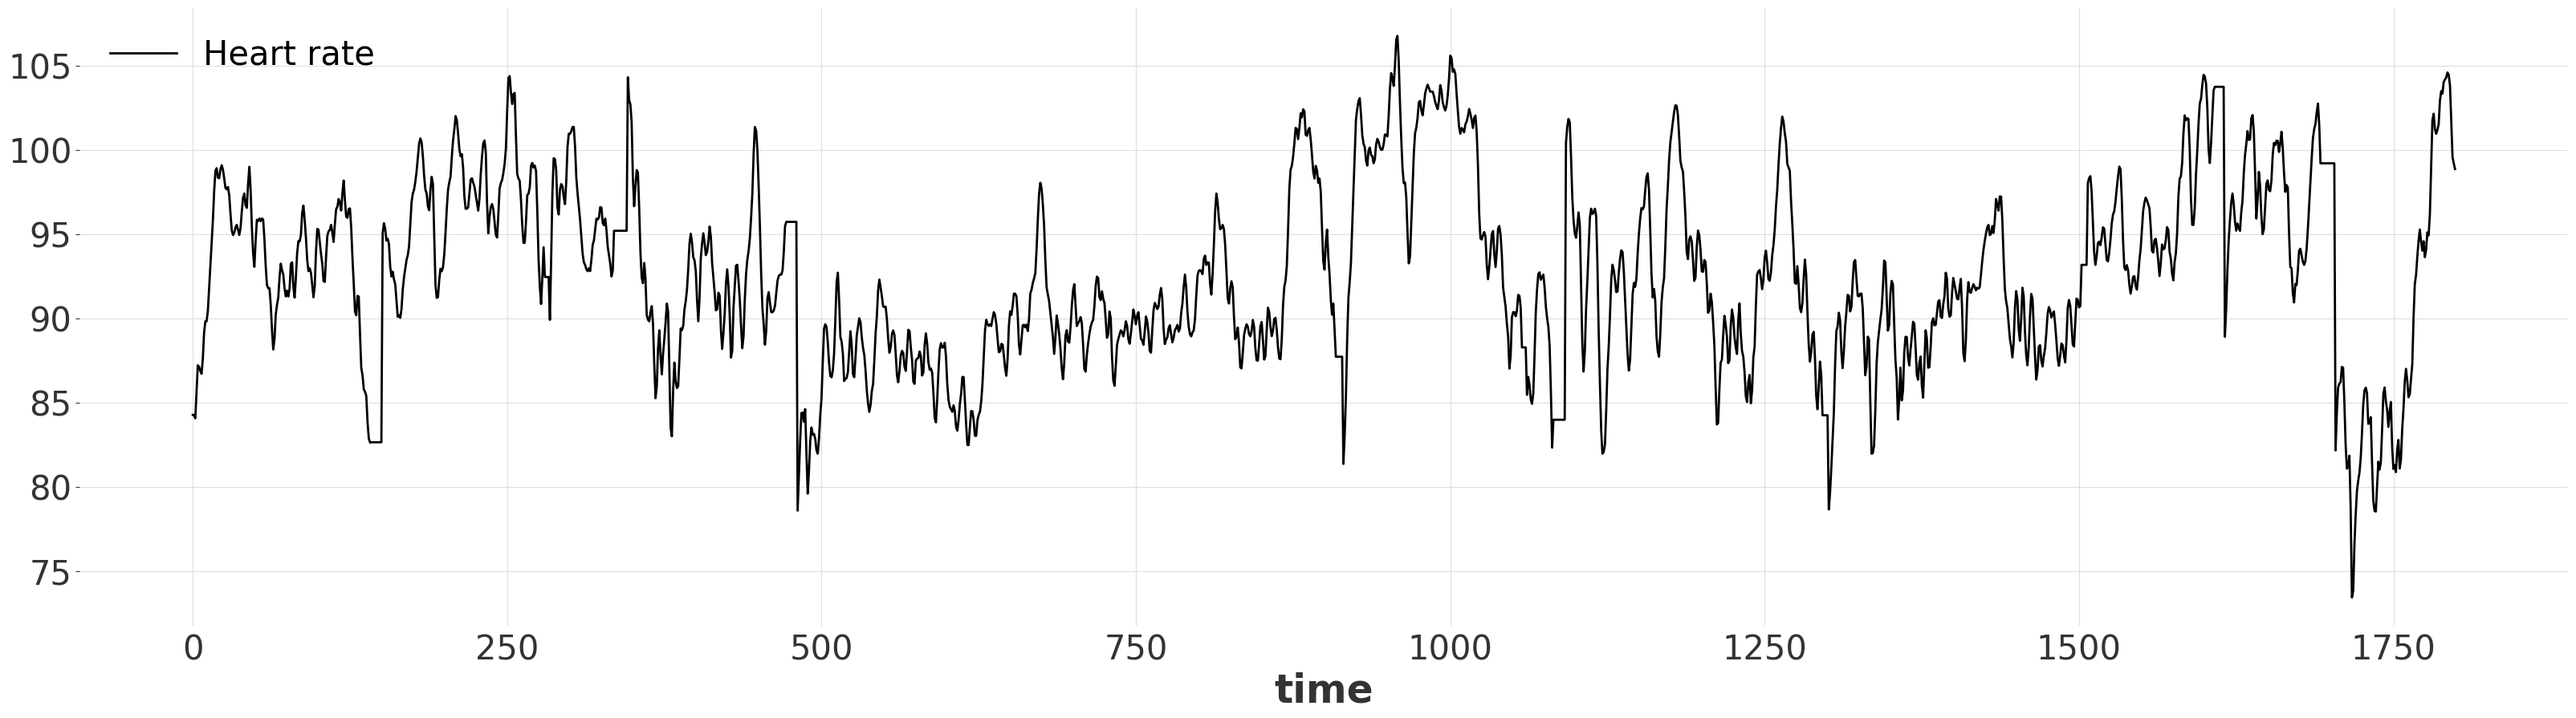

In [3]:
# Load the dataset
hr_ts = HeartRateDataset().load()
hr_ts.plot()
hr_df = hr_ts.pd_dataframe()
mean_value = np.mean(hr_df)
print(mean_value)

Number of Periods:  109


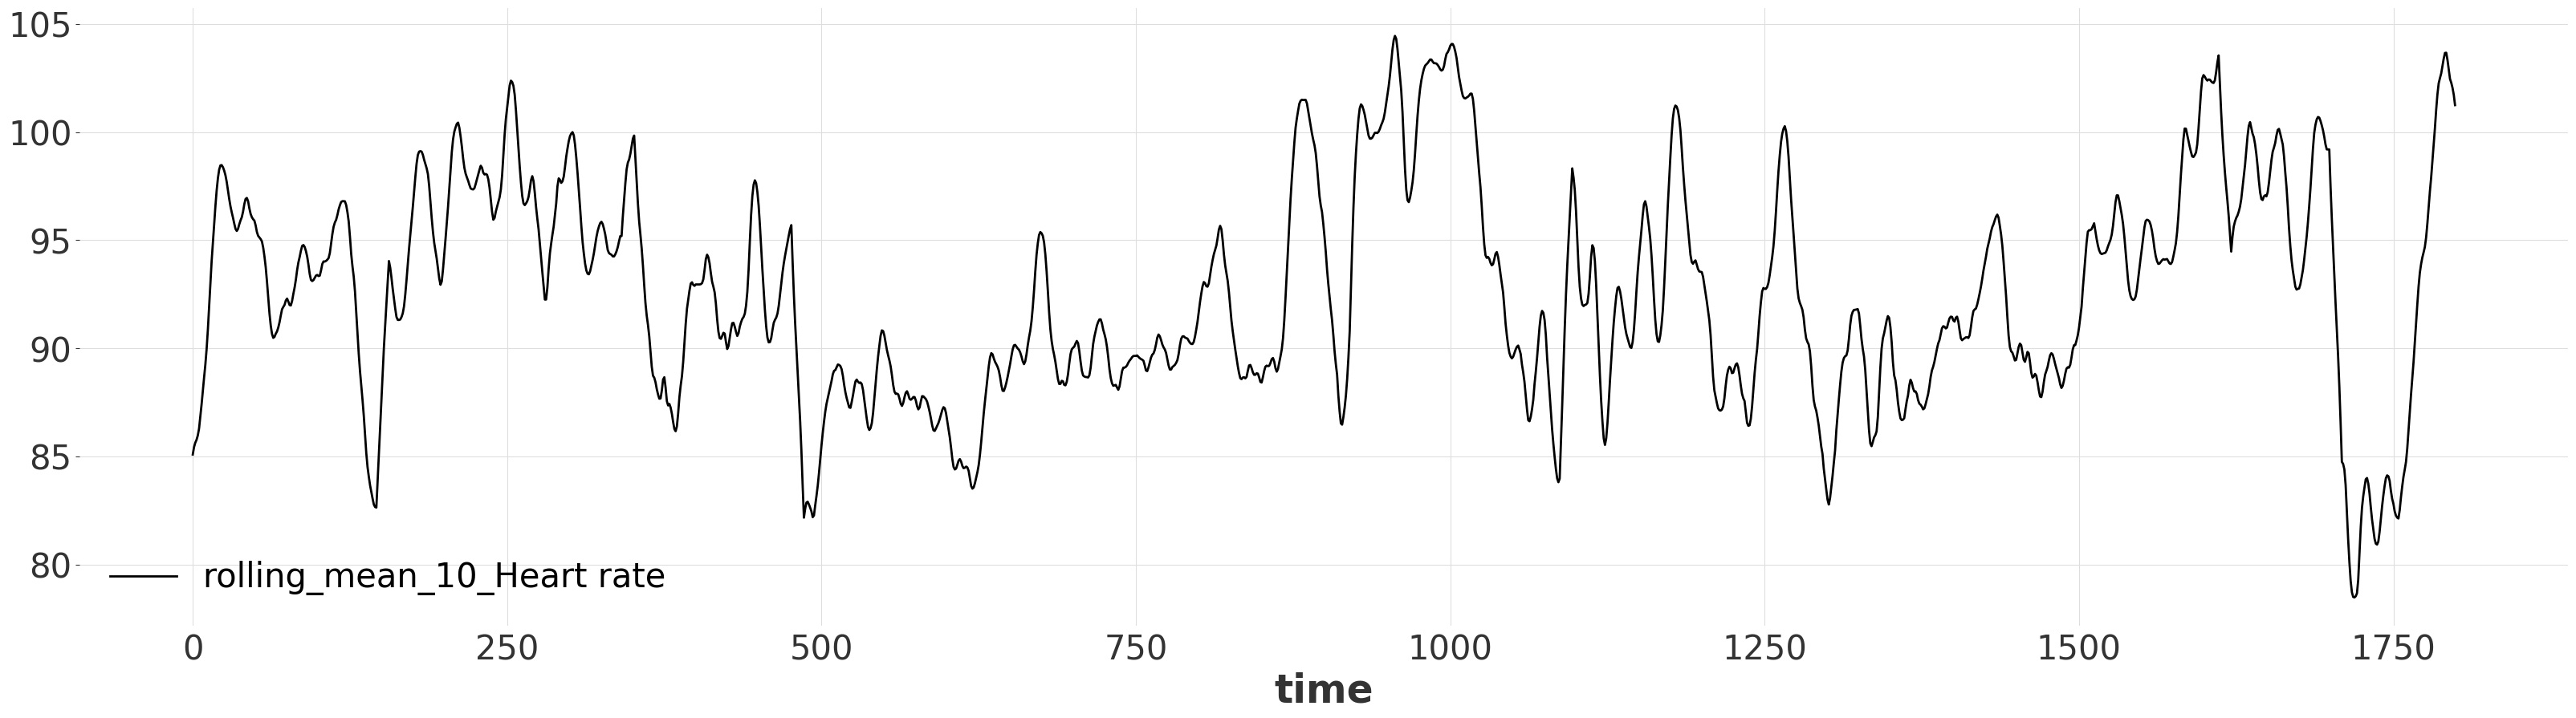

In [4]:
# Determine number of peaks
ts_smooth = MovingAverageFilter(window=10).filter(hr_ts)

ts_smooth.plot()

minimums = argrelextrema(ts_smooth.univariate_values(), np.greater)

periods = len(minimums[0])
print("Number of Periods: ", periods)

### Generate a Pattern to Compare With

Steps:  9
Length of the values:  1963


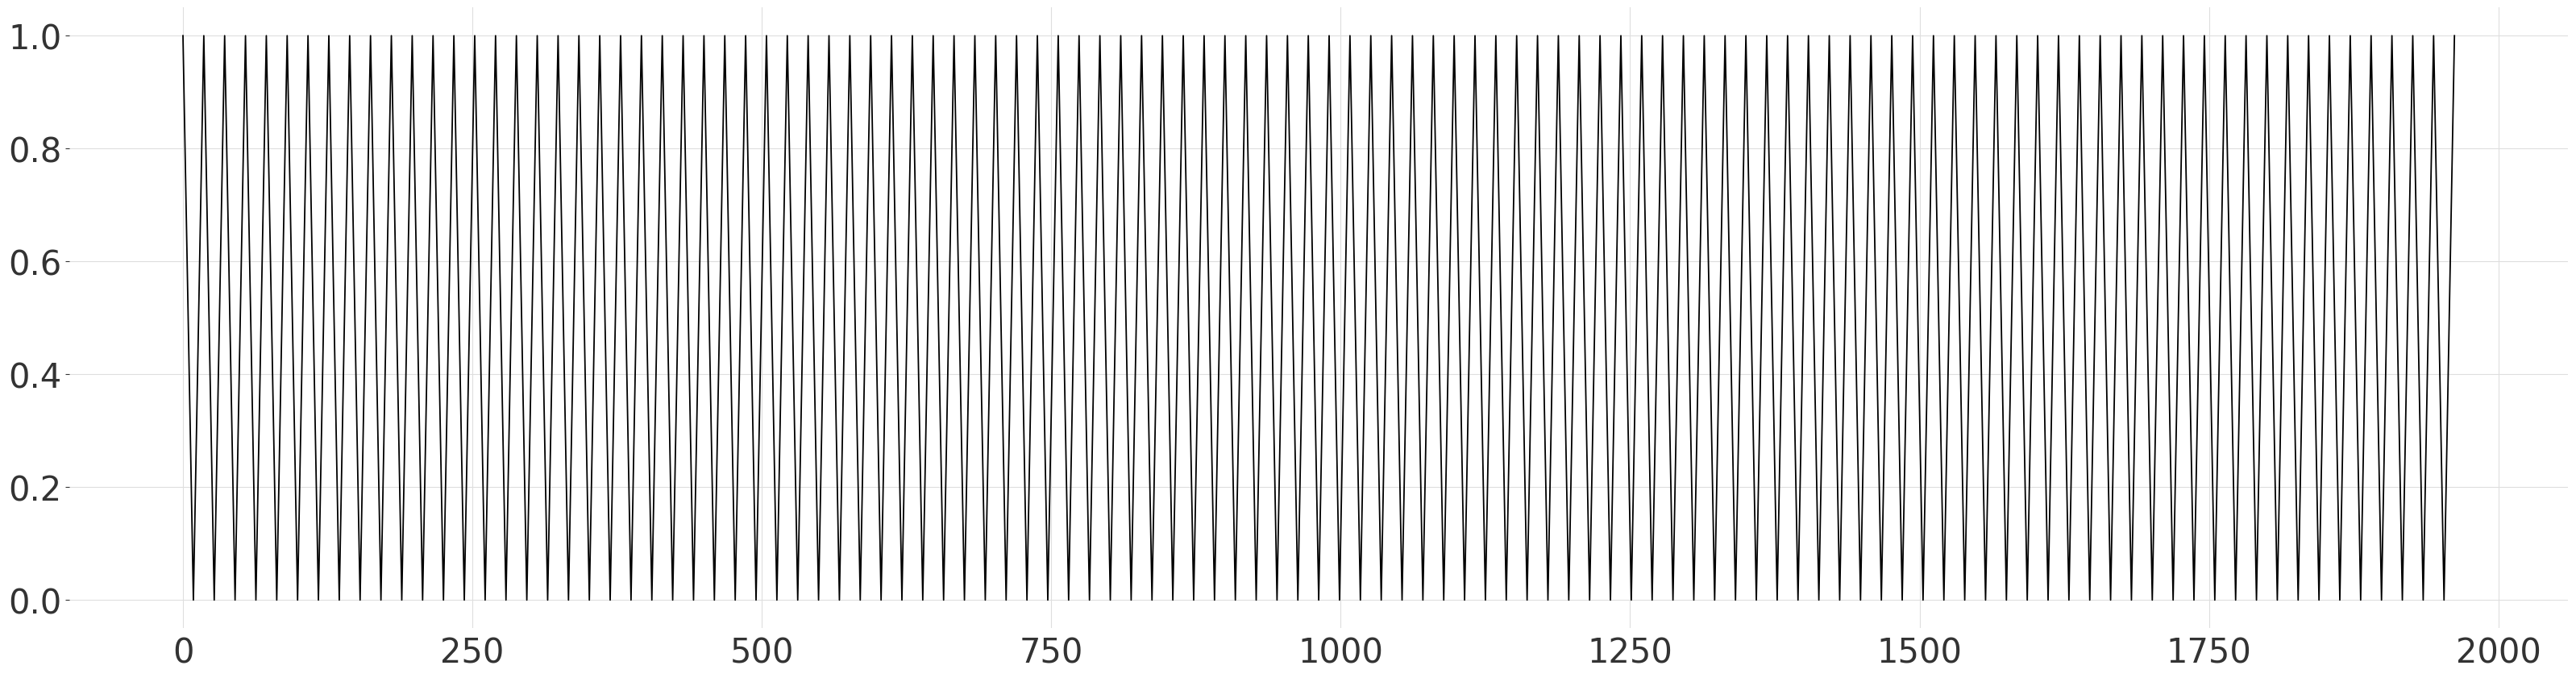

In [5]:
# Ensure that the mean is 0 and range is 1, to make it easier to fit to the data
steps = int(np.ceil(len(hr_ts) / (periods * 2)))
print("Steps: ", steps)
down = np.linspace(1.0, 0.0, steps + 1)[:-1]
up = np.linspace(0.0, 1.0, steps + 1)[:-1]

values = np.append(np.tile(np.append(down, up), periods), 1.0)
print("Length of the values: ", len(values))

plt.plot(np.arange(len(values)), values)


### Fit the Pattern to the Series

<Axes: xlabel='time'>

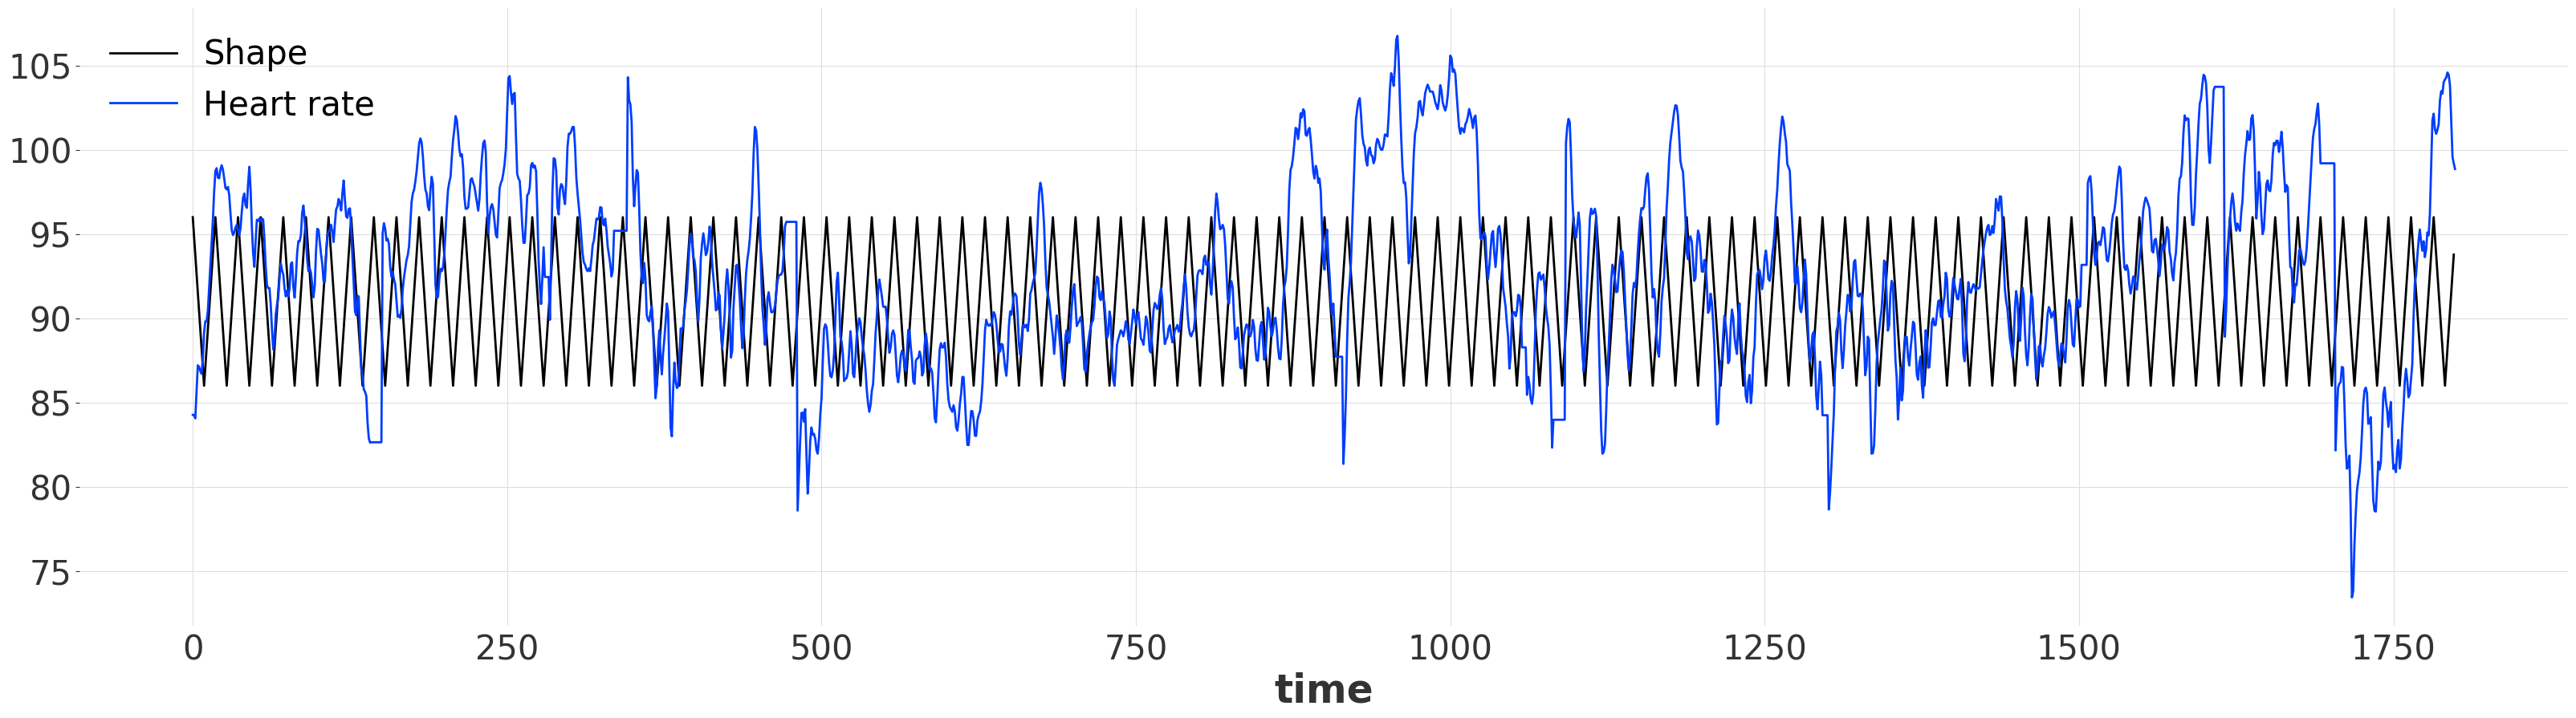

In [6]:
m = 10
c = 86

scaled_values = values * m + c


index_range = [x for x in range(0, len(values))]
ts_shape_series = pd.Series(scaled_values, index=index_range, name="Shape")

ts_shape = TimeSeries.from_series(ts_shape_series)
ts_shape = ts_shape.drop_after(hr_ts.end_time())
ts_shape.plot()
hr_ts.plot()

### Quantitative Comparison

We can use MEAN ABSOLUTE ERROR also known as *mae*, to evaluate how closely our simple pattern fits the data. Looking at the plot above it is clear that that there is some fluctuation in the time between peaks, leading to a misalignment and a relatively high error.

In [7]:
original_mae_result = mae(hr_ts, ts_shape)
original_mae_result

5.12531232166018

### Dynamic Time Warping

Finding the optimal alignment between two series is exactly what DTW was designed for!

#### No Window

Exact evaluation will result in poor performance on large datasets. Consider enabling multi-grid or using a window.


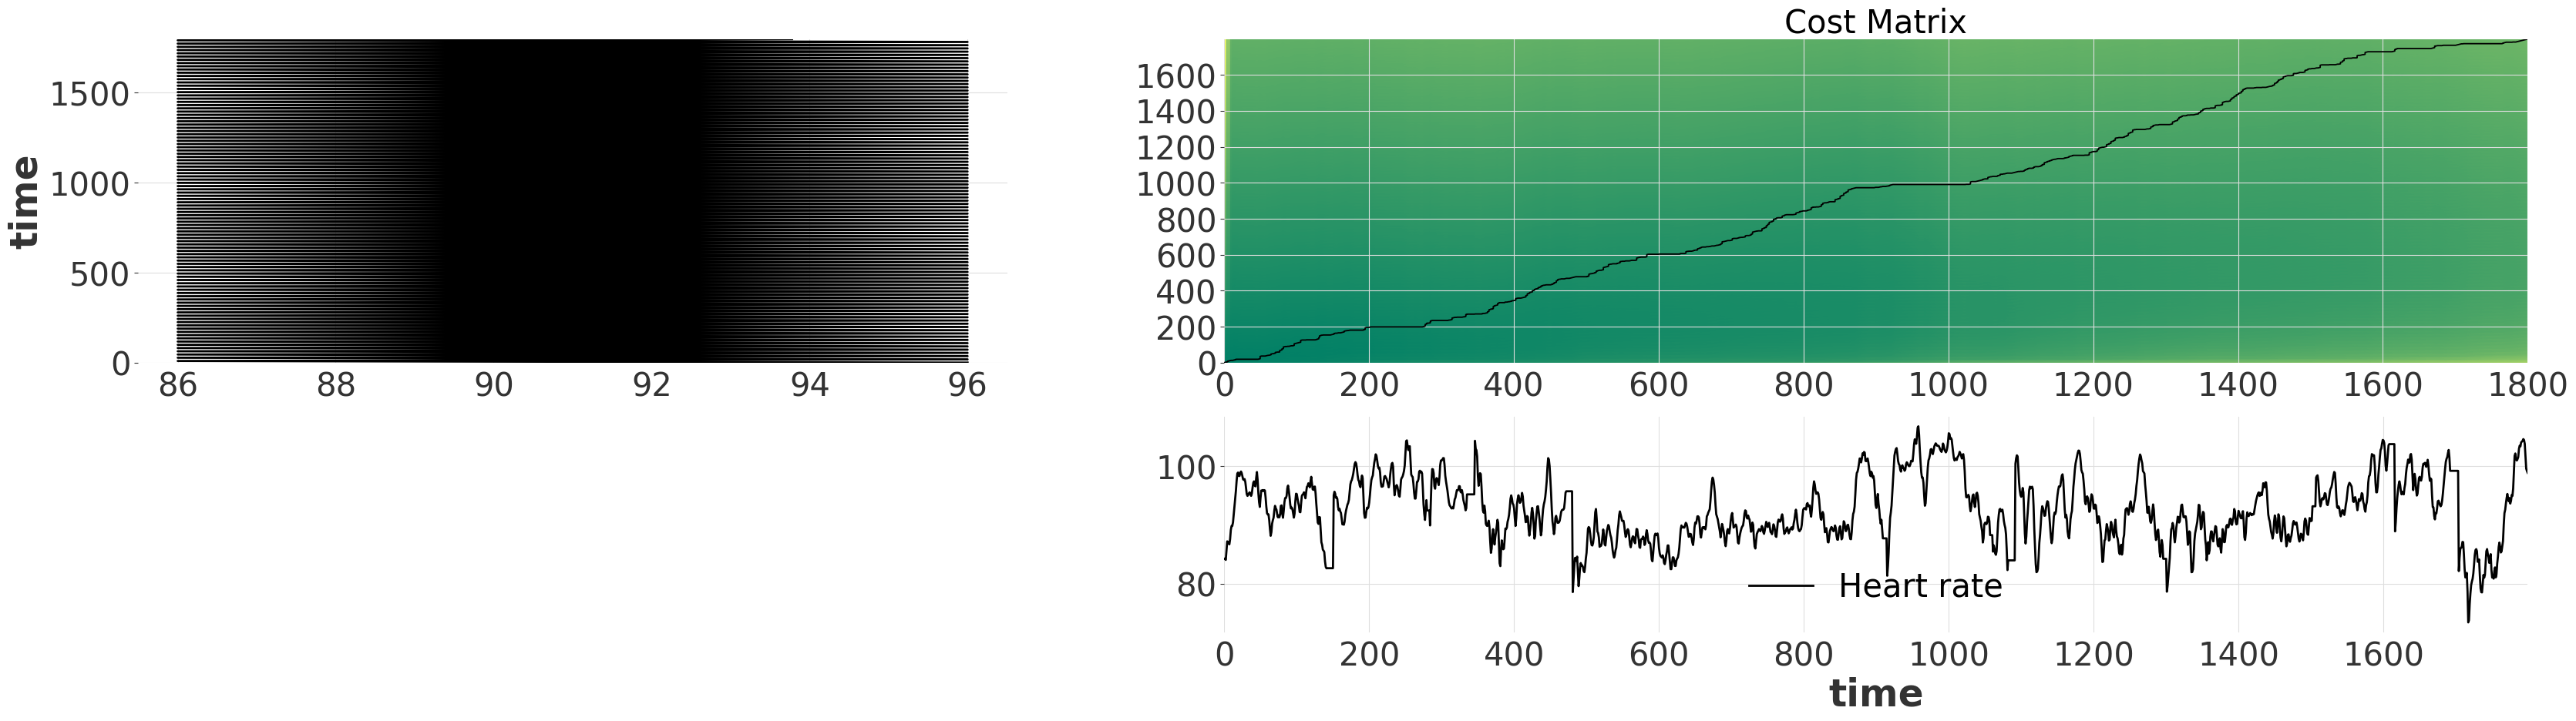

In [8]:
exact_alignment = dtw.dtw(hr_ts, ts_shape)
exact_alignment.plot(show_series=True)

#### Multi-Grid

On large datasets, computing every possible alignment rapidly becomes computationally expensive (quadratic complexity).

The multi-grid solver, which operates in almost linear time, is an alternative. On a smaller grid, the solver first finds the ideal path. It then iteratively reprojects and refines the path, increasing the resolution each time. Without significantly sacrificing accuracy, only turning on the multi-grid solution (linear complexity) will typically result in a significant speed increase.

The parameter *multi_grid_radius* controls how much to extend the search window by from the path found at a lower resolution. In other words, you gain accuracy at the cost of performance by increasing it.

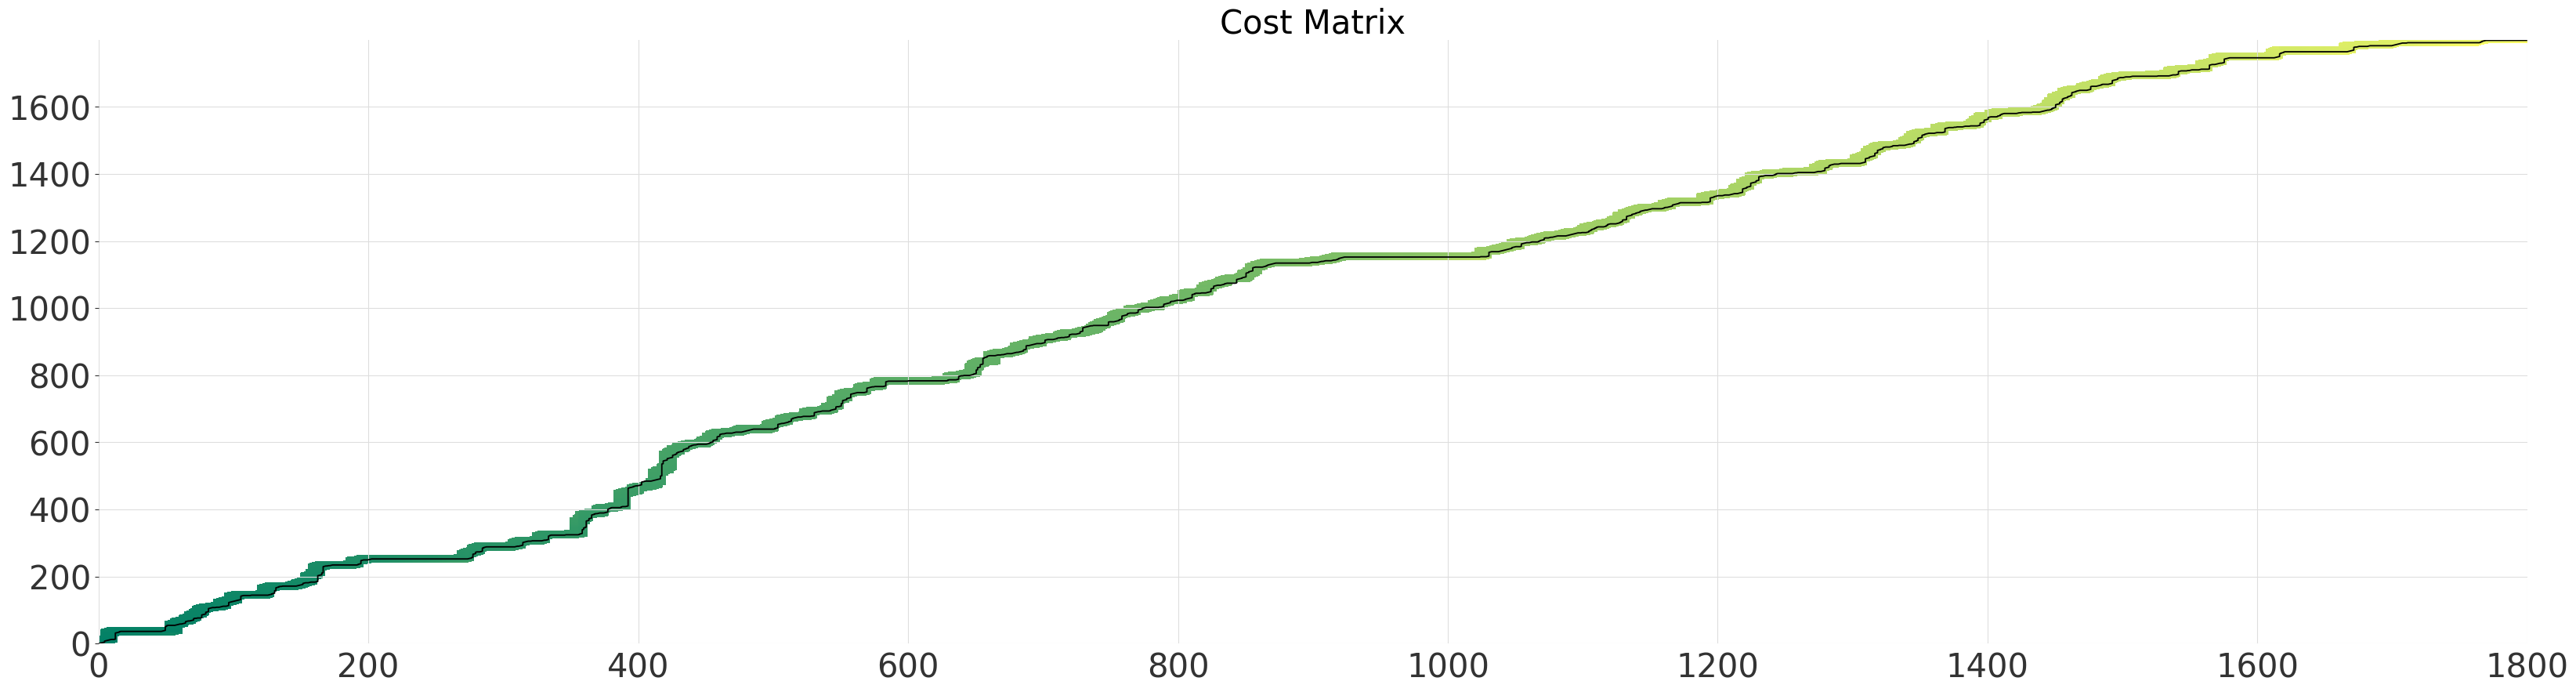

In [9]:
multi_grid_radius = 10

multigrid_alignment = dtw.dtw(hr_ts, ts_shape, multi_grid_radius=multi_grid_radius)
multigrid_alignment.plot()

#### Diagonal Window (SakoeChiba)

The SakoeChiba window forms a diagonal band, determined by the window_size parameter. The window is best applied when you know that the two time series are already mostly aligned or want to constrain the amount of warping. It will ensure that element n in one series, is only every matched with element n-window_size in the other.

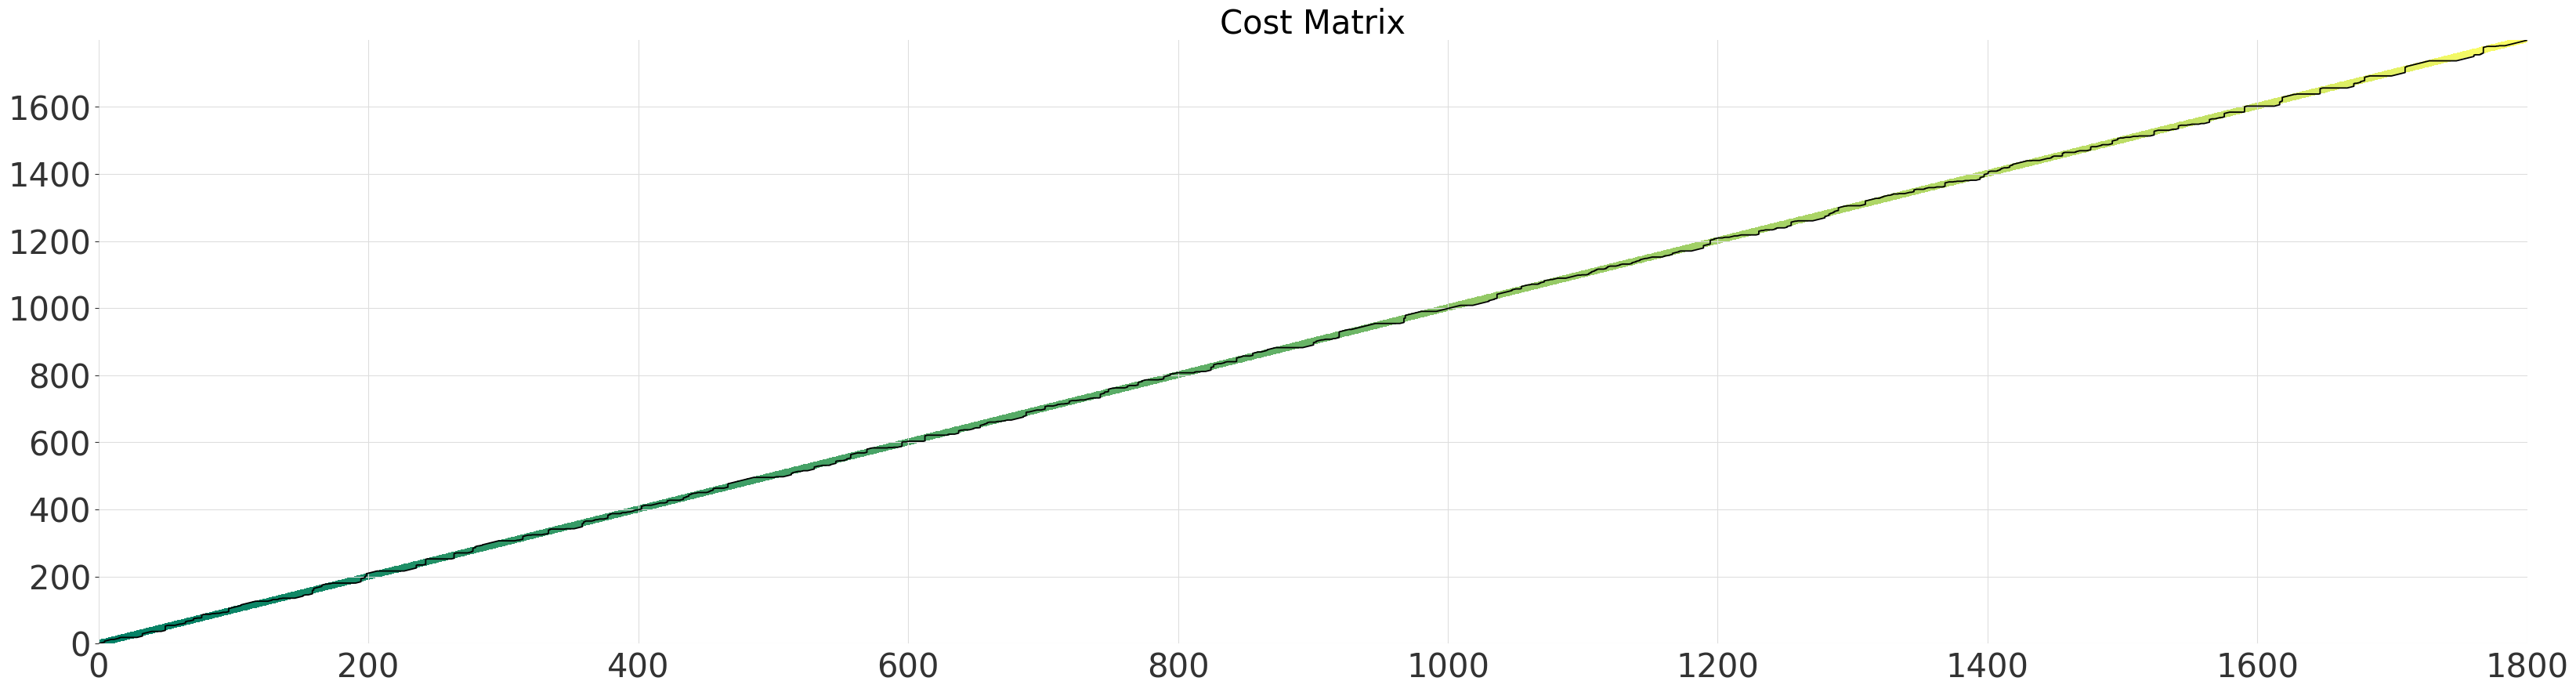

In [10]:
sakoechiba_alignment = dtw.dtw(hr_ts, ts_shape, window=dtw.SakoeChiba(window_size=10))
sakoechiba_alignment.plot()

#### Parallelogram Window (Itakura)

The parameter max_slope controls the gradient of the steeper side of the parallelogram. For our time-series the window is somewhat wastefull as the optimal path does not deviate significantly from the diagonal.

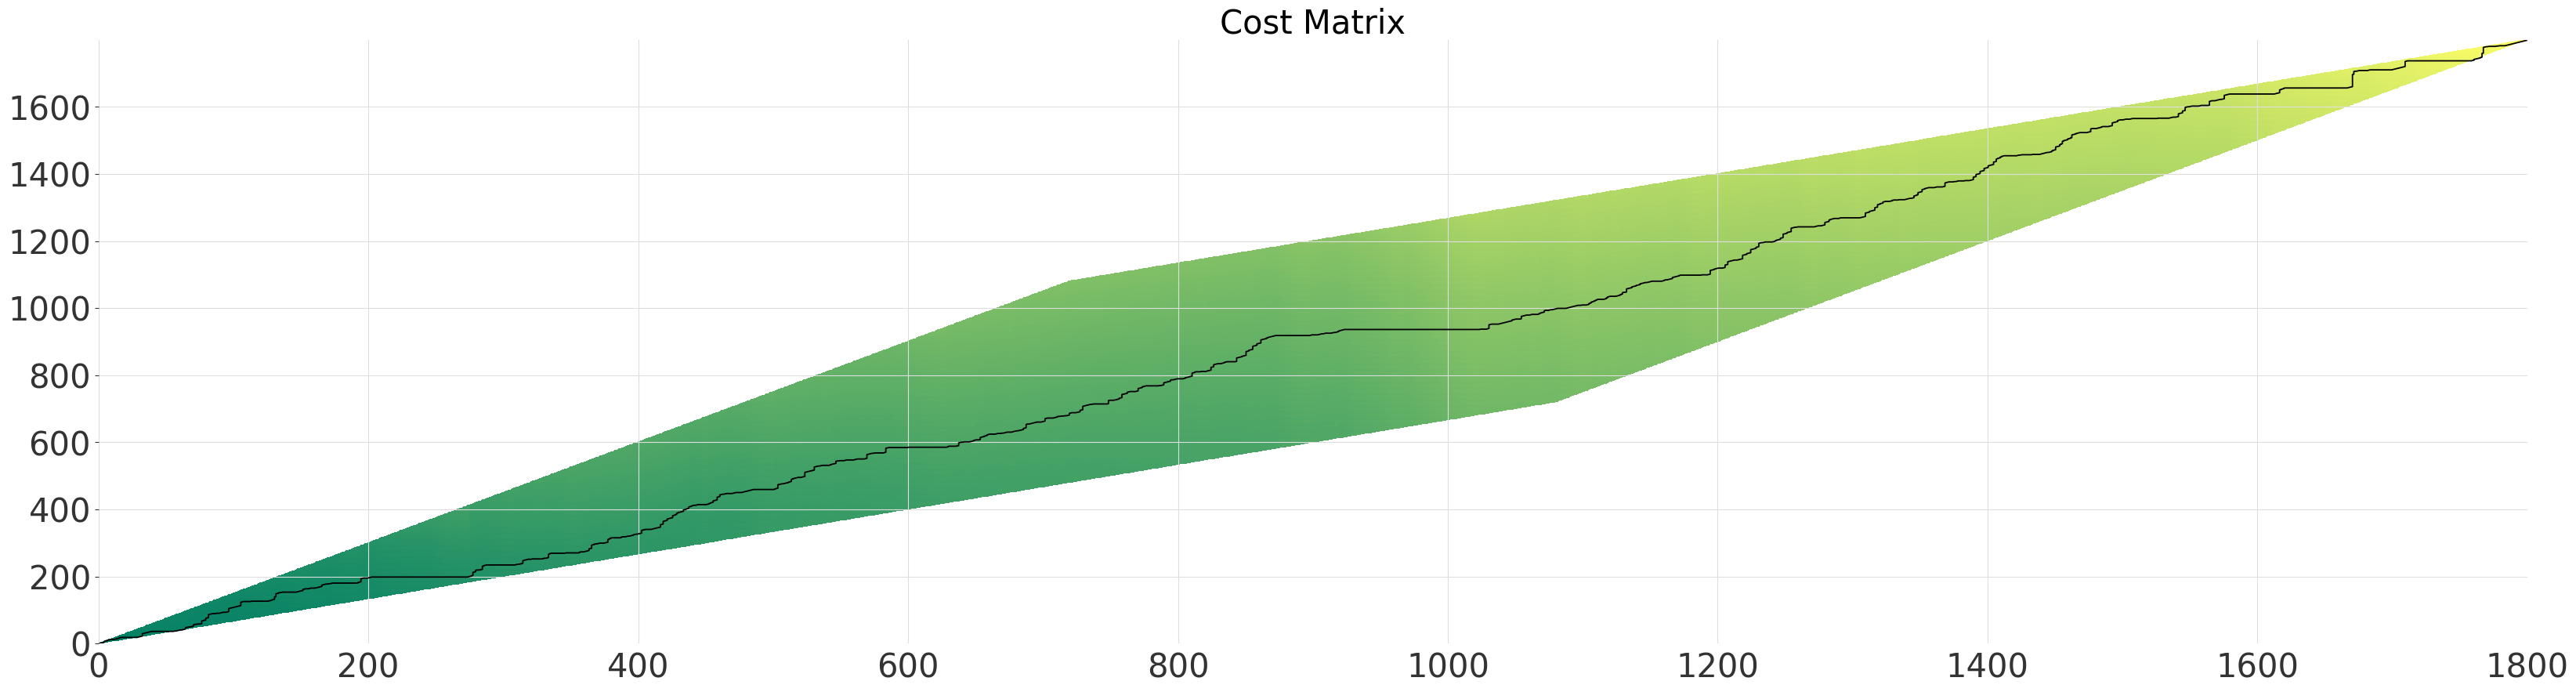

In [11]:
itakura_alignment = dtw.dtw(hr_ts, ts_shape, window=dtw.Itakura(max_slope=1.5))
itakura_alignment.plot()

#### Warped Time Series

Once we have found an aligment, we can produce two warped series, of the same length. Since we’ve warped the time dimension, by default the new warped series are indexed by pd.RangeIndex. Now our simple pattern matches up with the series, despite them not doing so originally!

<Axes: xlabel='time'>

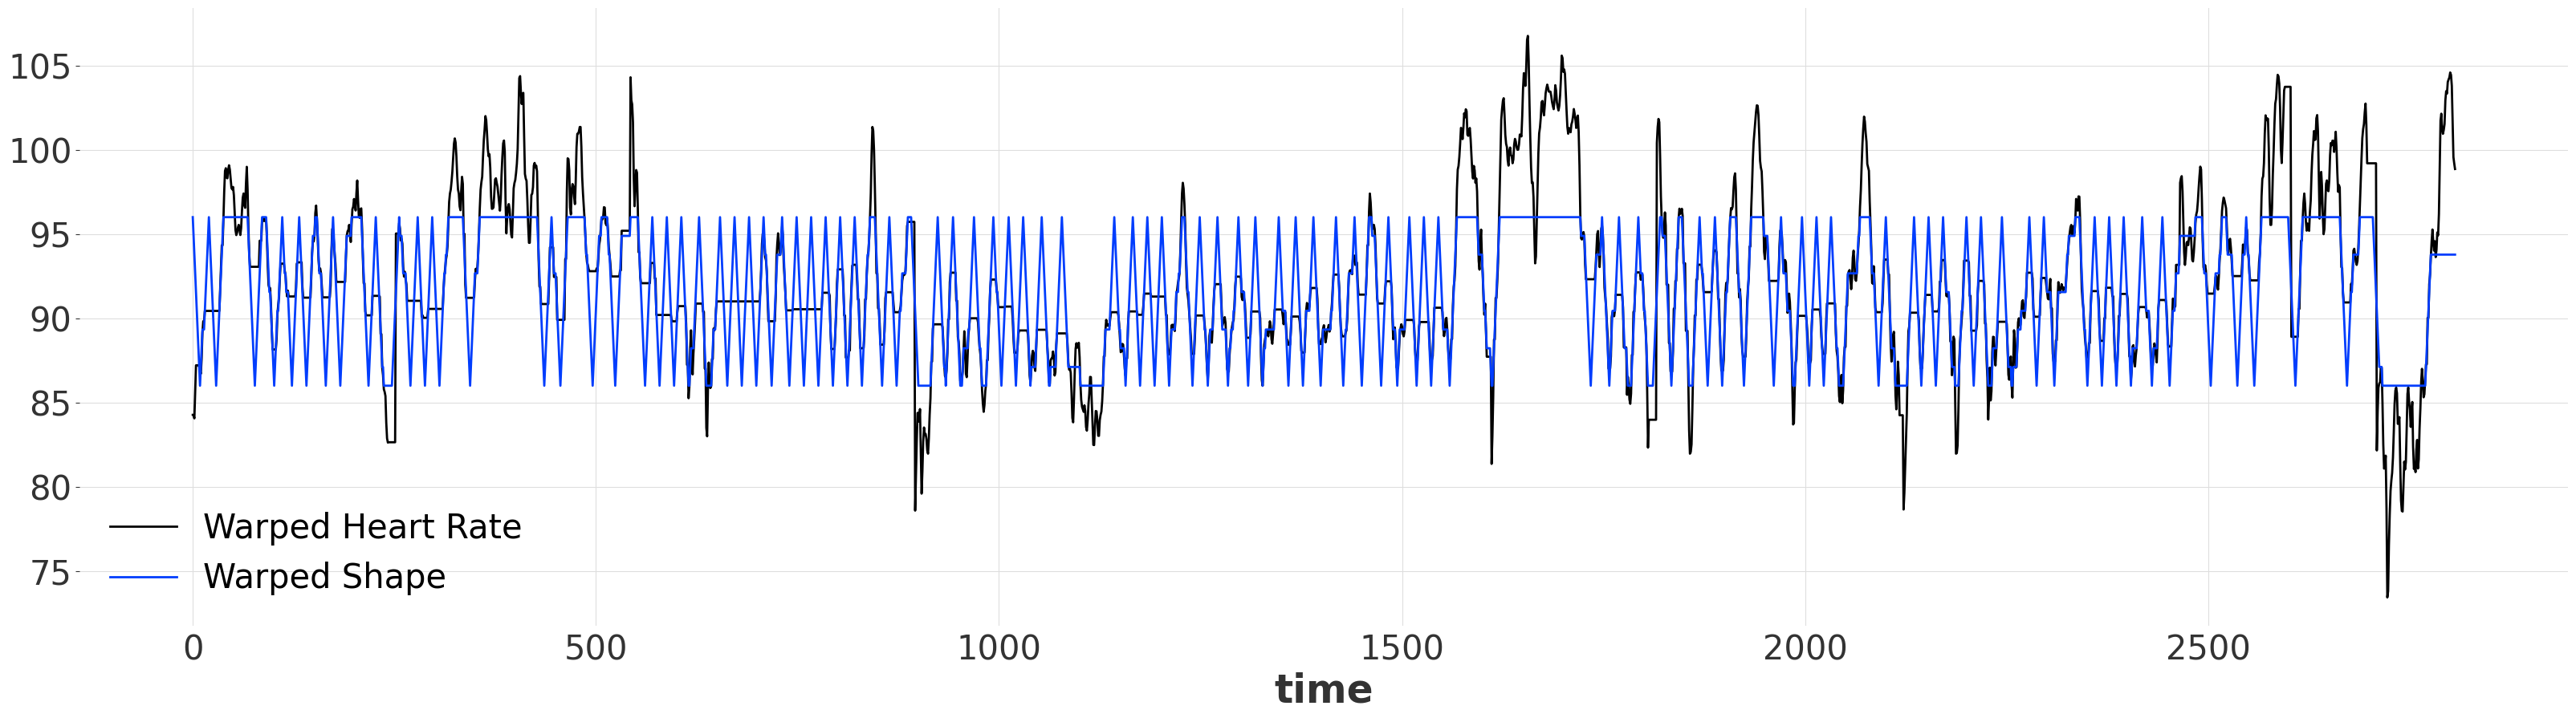

In [12]:
warped_ts, warped_ts_shape = multigrid_alignment.warped()

warped_ts.plot(label="Warped Heart Rate")
warped_ts_shape.plot(label="Warped Shape")

#### Quantitative Comparison

We can again apply the mae metric, however this time to our warped series. If we were interested only in the similarity after warping, we could also just have called the helper function dtw_metric. Notice the ~63% reduction in the error between the warped series!

Original:  5.12531232166018
Warped:  1.9134849978229027
Metric:  1.9134849978229027


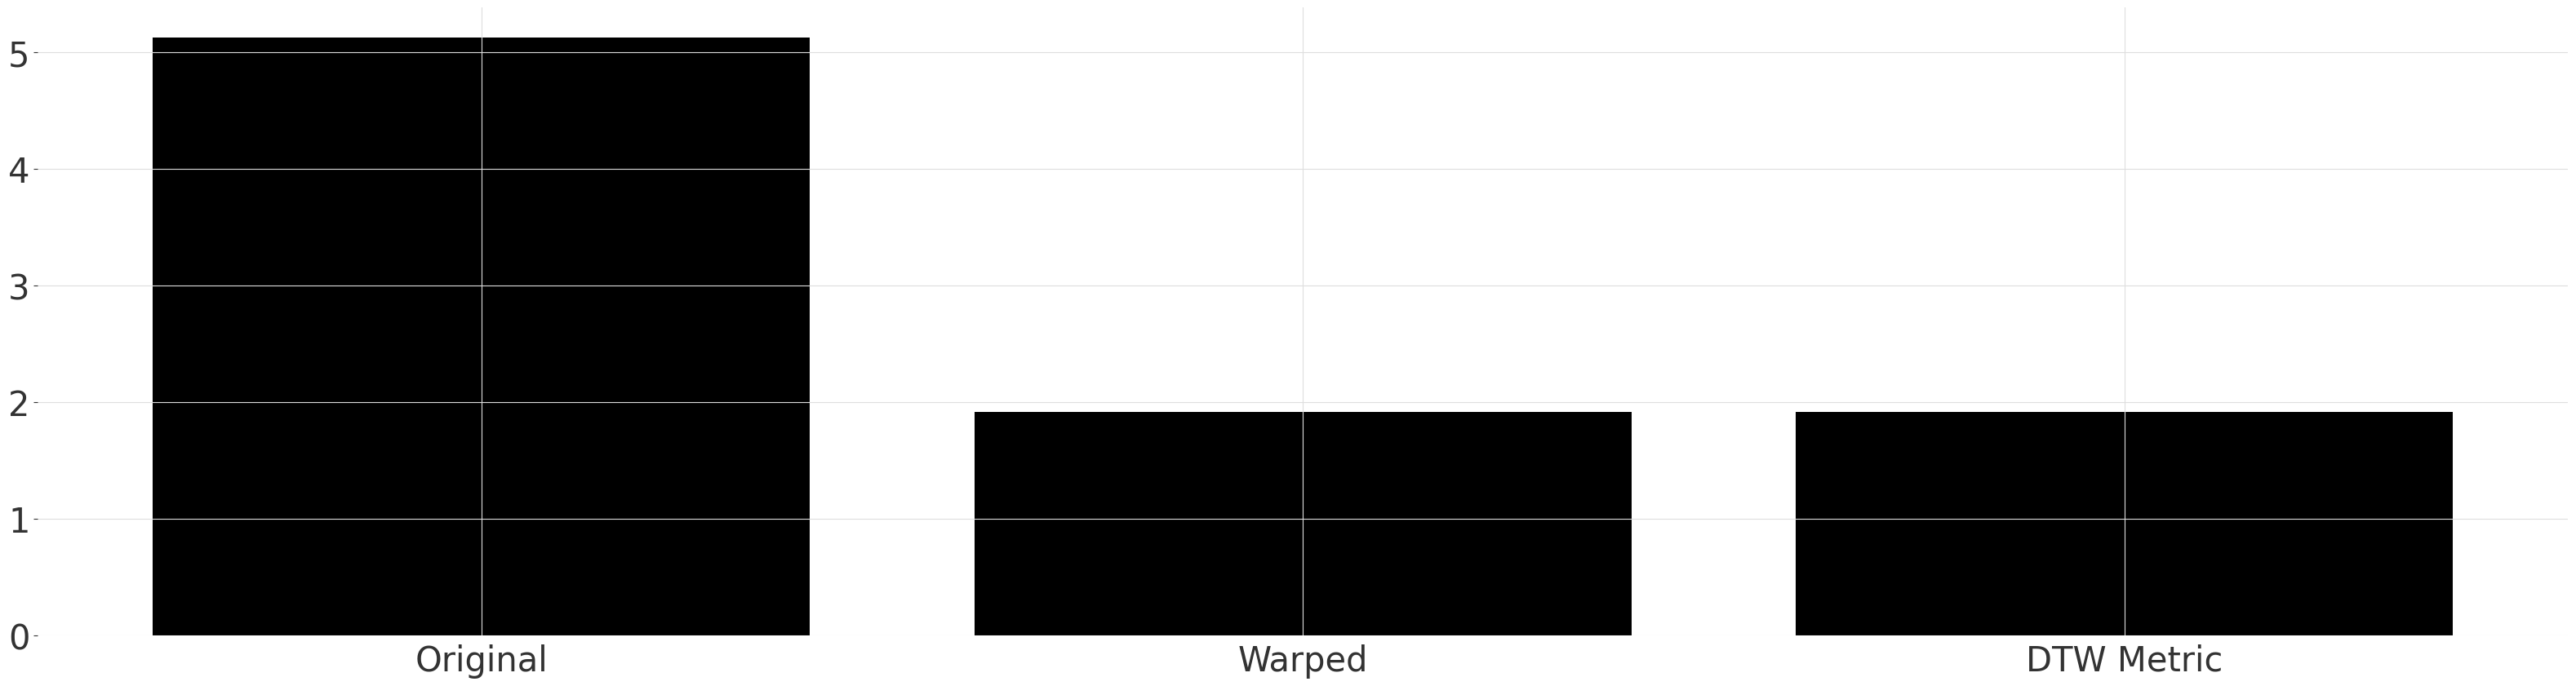

In [13]:
warped_mae = mae(warped_ts, warped_ts_shape)
warped_dtw = dtw_metric(hr_ts, ts_shape, metric=mae, multi_grid_radius=multi_grid_radius)

plt.bar(["Original", "Warped", "DTW Metric"], [original_mae_result, warped_mae, warped_dtw])
print("Original: ", original_mae_result)
print("Warped: ", warped_mae)
print("Metric: ", warped_dtw)